# Eye Tracking Data Pre-processing

At this point we are down from 719 to 568 resting-state scans due to: a) 149 scans with missing ET data, 2 scans with broken ET data, 4 scans with wrong freesurfer parcellation, and 1 scan with missing samples. 

Eye tracking pre-processing consisted of the following steps:

1. Remove pupil size samples that fell outside the temporal span of each fMRI scan to achieve temporal synchronization.
2. Blink artifact removal: any period of missing pupil size data shorter than 1 second was considered a blink, and data within that period was linearly interpolated between the onset and offset of the blink. 
3. Remove short bursts (< 1ms) of pupil size data scattered within periods of eye closureto ensure the continuity and correct identification of long periods of eye closure.
4. Pupil size traces acquired at 500Hz (which is the case for 68 scans) were linearly upsampled to 1KHz to match the rest of the sample. 
5. Pupil size traces were temporally smoothed using a 200ms Hanning window.
6. Pupil size traces were downsampled to 1Hz in order to match the temporal resolution of the fMRI data. 
7. Removed the first 10 seconds of data to match pre-processing of fMRI data.
8. Remove isolated single pupil size samples or empty spaces. 

During pre-processing, there are a few extra errors that may lead to discarding additional scans. These include:

a. Synchornization info missing [4 runs]
b. ET traces shorter than fMRI traces [3 runs]

As a result of this, we go down from 568 runs to 561 runs to be included in further analyses.

### Outputs of this notebook

* ```./Resources/ET_info.pkl```: contains one row per resting-state run with information such as: ET sampling rate, ET data complete?, ET onset available?, number of fixations, percent of missing samples in ET data.
* ```./Resources/ET_PupilSize_Orig.pkl)```: contains one column per resting-state run (561 of them) with the raw ET traces.
* ```./Resources/ET_PupilSize_Proc.pkl)```: contains one column per resting-state run (561 of them) with partially processed ET traces (step 1 - 5) 
* ```./Resources/ET_PupilSize_Proc_1Hz.pkl)```: contains one column per resting-state run (561 of them) with partially processed ET traces (step 1 - 6)
* ```./Resources/ET_PupilSize_Proc_1Hz_corrected.pkl)```: contains one column per resting-state run (561 of them) with fully preprocessed ET data (steps 1 - 8)
* ```<DATA_DIR>/<SBJ_DIR>/<RUN_DIR>/<RUN>.ET_PupilSize_Preproc_1Hz_corrected.pkl```: fully pre-processed ET data for each individual run will be also saved in each run folder.
***

In [1]:
import numpy  as np
import pandas as pd
import os.path as osp
import hvplot.pandas
import holoviews as hv
import time
from utils.ParseEyeLinkAsc import ParseEyeLinkAsc
from utils.basics    import get_available_runs, smooth, alt_mean
from utils.variables import DATA_DIR, Resources_Dir, ETinfo_path, ET_PupilSize_Orig_path, ET_PupilSize_Proc_path
from utils.variables import ET_Blink_Dur_Thr, ET_Blink_Buffer_NSamples, Ndiscard

In [2]:
def alt_mean(data):
    """
    This function provides an alternative way to compute the mean value for a window, taking into account how many missing points exists.
    
    If percentage of missing values is less or equal to pc_missing, then return the mean computed using all available datapoints
    
    Conversely, if the percentage of missing values is larger than the threshold, then return np.nan
    
    INPUTS:
    data: pandas dataframe with data for a given window
    pc_missing: percentage of missing data
    
    """
    pc_missing = 0.5
    l = data.shape[0]
    n_nans = data.isna().sum()
    if n_nans <= pc_missing * l:
        return data.mean()
    else:
        return np.nan

# 1. Load Results from QA1

The runs listed below all have: ET data available, ET data loadable, correct parcellation for the 4th ventricle, correct TR, correct voxel size and correct number of volumes

In [3]:
Valid_Runs_QA1 = get_available_runs('post_qa1')
print('++ INFO: Number of Runs that passed QA1 = %d' % len(Valid_Runs_QA1))
np.savetxt(osp.join(Resources_Dir,'QA_Part1_GoodRuns.txt'),Valid_Runs_QA1,fmt='%s')

++ INFO: Number of Runs that passed QA1 = 568


In [4]:
NumET_Samples_1000Hz       = 900000                                           # 900s * 1000 Samples/sec = 900000 Samples
ET_PupilSize_Orig_df       = pd.DataFrame(index=range(NumET_Samples_1000Hz))  # This DataFrame will contain un-preproc traces of pupil size
ET_PupilSize_Orig_df.index = pd.to_timedelta(ET_PupilSize_Orig_df.index,unit='ms')

ET_PupilSize_Proc_df       = pd.DataFrame(index=range(NumET_Samples_1000Hz))  # This DataFrame will contain preproc    traces of pupil size
ET_PupilSize_Proc_df.index = pd.to_timedelta(ET_PupilSize_Proc_df.index,unit='ms')

In [5]:
ETinfo_df = pd.DataFrame()

# 2. Pre-processing steps 1 - 5

In [ ]:
%%time
# For each run that passed QA1
# ============================
for i,item in enumerate(Valid_Runs_QA1):
    start = time.time()
    sbj,run = item.split('_',1)
    print('++ Analyzing instance [%d] --> %s' % (i,item), end=' ')
    # Create Paths to ET files:
    # =========================
    ASC_Path = osp.join(DATA_DIR,sbj,run,'{run}_eyetrack.asc'.format(run=run))
    CSV_Path = osp.join(DATA_DIR,sbj,run,'{run}_eyetrack_summary.csv'.format(run=run))
    
    # Load ET Data (Raw):
    # ===================
    dfTrial,dfMsg,dfFix,dfSacc,dfBlink,dfSamples = ParseEyeLinkAsc(ASC_Path, verbose=False)
    dfSummary = pd.read_csv(CSV_Path)
    
    # Check whether or not Fixation Information is available, and create boolean variable accordingly:
    # ================================================================================================
    if dfFix is None:
        eye = 'L'                   # If dfFix was not created, we will assume the eye being tracked is the left eye
        num_fixations = np.nan
    else:
        eye = dfFix['eye'][0]
        num_fixations = dfFix.shape[0]
        
    # Check data is correct:
    # a) Onset is available
    if np.isnan(dfSummary['TRonset'][0]):
        QA_onset_avail = False
    else:
        QA_onset_avail = True
    # b) ET available for the complete scan duration
    if dfSummary['TRduration'][0]<900:
        QA_et_complete = False
    else:
        QA_et_complete = True
    # c) Sampling rate is 500 or 1000
    if (dfSummary['srate'][0] == 500) | (dfSummary['srate'][0] == 1000):
        QA_et_srate_ok = True
    else:
        QA_et_srate_ok = False
    
    # Decide whether or not to pre-process this run
    # =============================================
    if (QA_onset_avail == False) | (QA_et_complete == False) | (QA_et_srate_ok == False):
        Percentage_Samples_Equal_Zero = np.nan
        print('WARNING: QA_onset_avail = %s | QA_et_complete = %s | QA_et_srate_ok = %s' % (QA_onset_avail,QA_et_complete,QA_et_srate_ok), end=' ')
    else:
        # 1. Calculate Synchronization
        # ============================
        # fMRI Scans last 900s (TR=1s | #Acq=900)
        ET_Duration_sec = (dfTrial['tEnd'][0] - dfTrial['tStart'][0] ) / 1000   # Duration of ET Recording    [s]
        ET_SRate        = dfSummary['srate'][0]                                 # Eye Tracker Sampling Rate   [Hz]
        ET_Start        = dfTrial['tStart'][0]                                  # Eye Tracker Start TimePoint [ms]
        ET_End          = dfTrial['tEnd'][0]                                    # Eye Tracker End Timepoint   [ms]
        fMRI_Offset     = dfSummary['TRonset'][0]*1000                          # Offset between ET Start and fMRI Start [ms]
        fMRI_Start      = int(ET_Start + fMRI_Offset)                           # Index to first ET sample aligned to the fMRI data
        fMRI_End        = fMRI_Start + NumET_Samples_1000Hz                     # Index to last ET sample aligned to the fMRI data
                          #NOTE: We assume 1000Hz becuase the first operation is going to be to upsample the 500Hz cases.
                            
        # 1. Remove Blinks
        # =================
        # NOTE: Blink removal is performed prior to upsampling to avoid interference of spikes at corners of blinks during
        #       the resample process. 
        # NOTE2: I use a threshold of 1s given blinks are shorter than that, and 1s is the fMRI resolution
            
        # 1.1 Compute periods of eye opening
        # ----------------------------------
        dfOpenEyes=pd.DataFrame(columns=['eye','tStart','tEnd','duration'])
        for b in range(dfBlink.shape[0]-1):
            dfOpenEyes = dfOpenEyes.append({'eye':dfBlink.loc[b]['eye'],
                    'tStart':dfBlink.loc[b]['tEnd'],
                    'tEnd':dfBlink.loc[b+1]['tStart'],
                    'duration':dfBlink.loc[b+1]['tStart'] - dfBlink.loc[b]['tEnd']}, ignore_index=True)
            
        # 1.2 Set short blinks to NaN (so they are interporlated) and long ones to zero (eyes closed)
        # -------------------------------------------------------------------------------------------
        dfSamples[eye+'Pupil_Rem_Blinks']  = dfSamples[eye+'Pupil']
        for bidx in list(dfBlink.index):
            thisBlink_duration = dfBlink.loc[bidx]['duration']
            if thisBlink_duration <= ET_Blink_Dur_Thr:
                dfSamples.loc[(dfSamples['tSample']>=(dfBlink.loc[bidx]['tStart']-ET_Blink_Buffer_NSamples)) & (dfSamples['tSample']<=dfBlink.loc[bidx]['tEnd']+ET_Blink_Buffer_NSamples),eye+'Pupil_Rem_Blinks'] = np.nan
            else:
                dfSamples.loc[(dfSamples['tSample']>=(dfBlink.loc[bidx]['tStart']-ET_Blink_Buffer_NSamples)) & (dfSamples['tSample']<=dfBlink.loc[bidx]['tEnd']+ET_Blink_Buffer_NSamples),eye+'Pupil_Rem_Blinks'] = 0.0
                
        # 1.3 Very short periods of eye opening get also set to zero. Those are like small spikes within longer periods of eye closing 
        # ----------------------------------------------------------------------------------------------------------------------------
        for oidx in list(dfOpenEyes.index):
            thisOpenPeriod_duration = dfOpenEyes.loc[oidx]['duration']
            if thisOpenPeriod_duration <= 100:
                dfSamples.loc[(dfSamples['tSample']>=(dfOpenEyes.loc[oidx]['tStart']-ET_Blink_Buffer_NSamples)) & (dfSamples['tSample']<=dfOpenEyes.loc[oidx]['tEnd']+ET_Blink_Buffer_NSamples),eye+'Pupil_Rem_Blinks'] = 0.0
                #print('++ WARNING: Burst of data within EC period detected: {sbj},{run},{onset}-{offset}'.format(sbj=sbj,run=run,onset=dfOpenEyes.loc[oidx]['tStart'],offset=dfOpenEyes.loc[oidx]['tEnd']))
            
        # 1.4 Interpolate NaNs (Actual Removal of Blinks)
        # -----------------------------------------------
        dfSamples[eye+'Pupil_Interpolate'] = dfSamples[eye+'Pupil_Rem_Blinks'].interpolate(method='linear')
        dfSamples.loc[dfSamples[eye+'Pupil_Interpolate']==0.0,eye+'Pupil_Interpolate'] = np.nan # By the end of pre-processing missing data (EC periods) should be np.nans 
                                                                                                    # (the use of zeros was a temporary trick to avoid interpolation for non-blinks)
        # 2. Upsampling to 1000Hz for everybody
        # =====================================
        PupilSize          = pd.DataFrame(index=range(NumET_Samples_1000Hz))   # a) Create empty DataFrame for Synchronized Pupil Size Traces
        PupilSize.index    = pd.to_timedelta(PupilSize.index,unit='ms')        # b) Set the index to ms
        if ET_SRate == 1000:
            # Pupil Size Data (Just copy the data starting and ending at the correct sample for synchornization to fMRI)
            for data_type in ['Pupil','Pupil_Rem_Blinks','Pupil_Interpolate']:
                PupilSize[eye+data_type]       = dfSamples.loc[(dfSamples['tSample'] >= fMRI_Start) & (dfSamples['tSample'] < fMRI_End)][eye+data_type].values
        if ET_SRate == 500:
            # Pupil Size Data: a) Fill with Nans, b) Put samples every two positions (becuase of 500Hz), c) interpolate the intermediate np.nans
            for data_type in ['Pupil','Pupil_Rem_Blinks','Pupil_Interpolate']:
                PupilSize[eye+data_type]                          = np.nan*np.ones(NumET_Samples_1000Hz)
                PupilSize.loc[::int(1000/ET_SRate),eye+data_type] = dfSamples.loc[(dfSamples['tSample'] >= fMRI_Start) & (dfSamples['tSample'] < fMRI_End)][eye+data_type].values
                # ======================================================================================================================================================================================
                # IMPORTANT: Alternative interpolation method to make sure we are only adding samples, when the gap is a single np.nan, otherwise interpolate, will still add one sample where there was
                # many np.nans (e.g., bigger gaps)
                # ======================================================================================================================================================================================
                # Interpolate begining and end if necessary
                if (np.isnan(PupilSize[eye+data_type][0])==True) &  (np.isnan(PupilSize[eye+data_type][1])==False):
                    PupilSize[eye+data_type][0] = PupilSize[eye+data_type][1]
                if (np.isnan(PupilSize[eye+data_type][-1])==True) &  (np.isnan(PupilSize[eye+data_type][-2])==False):
                    PupilSize[eye+data_type][-1] = PupilSize[eye+data_type][-2]
                # Interpolate anything else in the middle
                PupilSize[eye+data_type][PupilSize[eye+data_type].isnull()] = (PupilSize[eye+data_type].shift(-1) + PupilSize[eye+data_type].shift(1))/2
                #PupilSize[eye+data_type]                          = PupilSize[eye+data_type].interpolate(limit=1)
        # 3. Temporal Smoothing
        # =====================
        smooth_wl = 200
        PupilSize[eye+'Pupil_Smooth'] = smooth(PupilSize[eye+'Pupil_Interpolate'],window_len=smooth_wl)[int(smooth_wl/2):NumET_Samples_1000Hz+int(smooth_wl/2)]
        PupilSize.to_pickle(osp.join(DATA_DIR,sbj,run,run+'.PupilSize_1000Hz.pkl'))
        # 4. Copy into final DataFrame
        # ============================
        ET_PupilSize_Orig_df[item]    = PupilSize[eye+'Pupil']
        ET_PupilSize_Proc_df[item]    = PupilSize[eye+'Pupil_Smooth']
        # 5. Count the number of samples equal to zero
        # ============================================
        Percentage_Samples_Equal_Zero = 100*(PupilSize[eye+'Pupil']==0).sum()/NumET_Samples_1000Hz

    # 5. Update ETinfo_df
    # ===================
    ETinfo_df = ETinfo_df.append({'Sbj':sbj,
                                  'Run':run,
                                  'ET_Srate':ET_SRate,
                                  'ET_Eye':eye,
                                  'QA_ET_Complete':QA_et_complete,
                                  'QA_Onset_Avail':QA_onset_avail,
                                  'QA_SRate_OK':QA_et_srate_ok,
                                  'Num Fixations': num_fixations,
                                  'Percent_Zero_Samples': Percentage_Samples_Equal_Zero},ignore_index=True)
    stop = time.time()
    duration = stop-start
    print('... Elapsed time = %0.2f seconds' % duration)

Print some summary information about the intiial pre-processing of ET data

In [7]:
ETinfo_df['QA_ET_Complete'] = ETinfo_df['QA_ET_Complete'].astype(bool)
ETinfo_df['QA_Onset_Avail'] = ETinfo_df['QA_Onset_Avail'].astype(bool)
ETinfo_df['QA_SRate_OK']    = ETinfo_df['QA_SRate_OK'].astype(bool)
ETinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sbj                   568 non-null    object 
 1   Run                   568 non-null    object 
 2   ET_Srate              568 non-null    float64
 3   ET_Eye                568 non-null    object 
 4   QA_ET_Complete        568 non-null    bool   
 5   QA_Onset_Avail        568 non-null    bool   
 6   QA_SRate_OK           568 non-null    bool   
 7   Num Fixations         545 non-null    float64
 8   Percent_Zero_Samples  561 non-null    float64
dtypes: bool(3), float64(3), object(3)
memory usage: 28.4+ KB


Save some intermediate outputs to disk:

* ETinfo_df: contains info about initial pre-processing and the runs for which pre-processing could not be completed
* ET_PupilSize_Orig_df: original raw ET traces for the final 561 runs
* ET_PupilSize_Proc_df: partially pre-processed raw ET traces for the final 561 runs

In [8]:
# Save ET Info Dataframe to disk
ETinfo_df.to_pickle(ETinfo_path)

In [9]:
# Save Original ET data to disk
ET_PupilSize_Orig_df.to_pickle(ET_PupilSize_Orig_path)
# Save Pre-processed ET data to disk
ET_PupilSize_Proc_df.to_pickle(ET_PupilSize_Proc_path)

In [6]:
ETinfo_df = pd.read_pickle(ETinfo_path)
ET_PupilSize_Orig_df = pd.read_pickle(ET_PupilSize_Orig_path)
ET_PupilSize_Proc_df = pd.read_pickle(ET_PupilSize_Proc_path)

In [7]:
print('++ INFO: ETinfo_df.shape = %s' % str(ETinfo_df.shape))
print('++ INFO: ET_PupilSize_Orig_df.shape = %s' % str(ET_PupilSize_Orig_df.shape))
print('++ INFO: ET_PupilSize_Proc_df.shape = %s' % str(ET_PupilSize_Proc_df.shape))

++ INFO: ETinfo_df.shape = (568, 9)
++ INFO: ET_PupilSize_Orig_df.shape = (900000, 561)
++ INFO: ET_PupilSize_Proc_df.shape = (900000, 561)


Three subjects will be discarded becuase ET data does not cover the whole scan

In [8]:
ETinfo_df[ETinfo_df['QA_ET_Complete']==False]

,Sbj,Run,ET_Srate,ET_Eye,QA_ET_Complete,QA_Onset_Avail,QA_SRate_OK,Num Fixations,Percent_Zero_Samples
5,102311,rfMRI_REST3_PA,1000.0,L,False,True,True,932.0,NaN
198,185442,rfMRI_REST2_AP,1000.0,L,False,True,True,1684.0,NaN
331,352738,rfMRI_REST3_PA,1000.0,L,False,True,True,554.0,NaN


Four subjects will be discarded becuase onset information (needed for synchornization with fMRI) is missing

In [9]:
ETinfo_df[ETinfo_df['QA_Onset_Avail']==False]

,Sbj,Run,ET_Srate,ET_Eye,QA_ET_Complete,QA_Onset_Avail,QA_SRate_OK,Num Fixations,Percent_Zero_Samples
58,130518,rfMRI_REST2_AP,1000.0,L,True,False,True,102.0,NaN
104,146937,rfMRI_REST1_PA,500.0,L,True,False,True,24.0,NaN
369,401422,rfMRI_REST1_PA,1000.0,R,True,False,True,25.0,NaN
410,562345,rfMRI_REST2_AP,1000.0,L,True,False,True,191.0,NaN


# 3. Pre-processing Steps 6 - 8

### Step 6. Upsample to 1Hz

Interpolation of ET traces to the temporal resolution of fMRI is not trivial. 

For example, if we use np.nanmean, then we would be saying that eyes were open for a 1s period in which potentially we may only have 1 out of 1000 samples. That may not always be fair. 

In [10]:
%%time
ET_PupilSize_Proc_1Hz       = ET_PupilSize_Proc_df.resample('1s').apply(np.nanmean)

CPU times: user 4.04 s, sys: 1.64 s, total: 5.67 s
Wall time: 5.69 s


An alternative (hopefully fairer solution) is to only return a mean value different from np.Nan if at least half of the samples within a given 1 second period exists.

This is the interporlation scheme adopted in this work. The previous one is only performed for demonstration purposes

In [11]:
%%time
ET_PupilSize_Proc_1Hz_B     = ET_PupilSize_Proc_df.resample('1s').apply(alt_mean)

CPU times: user 57.7 s, sys: 1.92 s, total: 59.6 s
Wall time: 59.7 s


In [12]:
ET_PupilSize_Proc_1Hz_B.to_pickle(osp.join(Resources_Dir,'ET_PupilSize_Proc_1Hz.Sukru.pkl'))

In [13]:
[Nacq, Nruns ]              =  ET_PupilSize_Proc_1Hz_B.shape
print('++ Number of acquisitions = %d' % Nacq)
print('++ Number of runs = %d' % Nruns)

++ Number of acquisitions = 900
++ Number of runs = 561


Let's explore how the two interporlation schemes can lead to very different final traces @ 1Hz when there are empty periods in the data

In [14]:
ET_PupilSize_Proc_COPY             = ET_PupilSize_Proc_df.copy()
ET_PupilSize_Proc_1Hz_COPY         = ET_PupilSize_Proc_1Hz.copy()
ET_PupilSize_Proc_1Hz_B_COPY       = ET_PupilSize_Proc_1Hz_B.copy()
ET_PupilSize_Proc_COPY.index       = ET_PupilSize_Proc_COPY.index.total_seconds()
ET_PupilSize_Proc_1Hz_COPY.index   = ET_PupilSize_Proc_1Hz_COPY.index.total_seconds()
ET_PupilSize_Proc_1Hz_B_COPY.index = ET_PupilSize_Proc_1Hz_B_COPY.index.total_seconds()

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# Eyes Continously Open: '114823_rfMRI_REST2_AP'
# Eyes with Long periods of Eye Closing: '178243_rfMRI_REST2_AP'
sample_run=['178243_rfMRI_REST2_AP']

(0.0, 100.0)

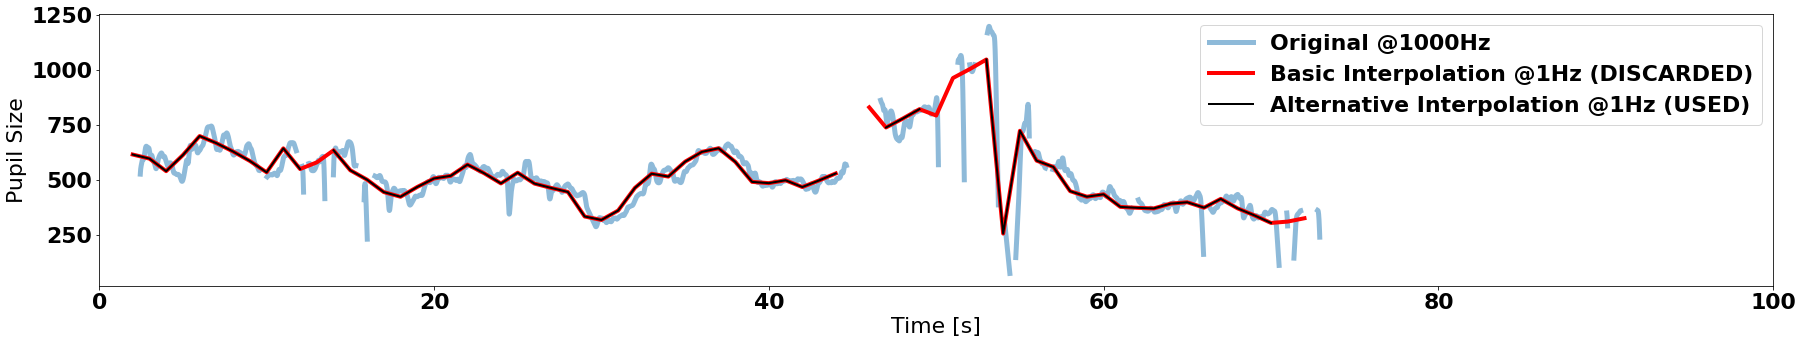

In [16]:
fig, axs = plt.subplots(1,1,figsize=(30,5))
line1 = axs.plot(ET_PupilSize_Proc_COPY[sample_run], lw=5, alpha=0.5, label='Original @1000Hz')
line2 = axs.plot(ET_PupilSize_Proc_1Hz_COPY[sample_run], lw=4, alpha=1, c='r', label='Basic Interpolation @1Hz (DISCARDED)')
line3 = axs.plot(ET_PupilSize_Proc_1Hz_B_COPY[sample_run], lw=2, alpha=1, c='k', label='Alternative Interpolation @1Hz (USED)')
axs.set_xlabel('Time [s]')
axs.set_ylabel('Pupil Size')
axs.legend()
axs.set_xlim(0,100)

In [17]:
del ET_PupilSize_Proc_COPY, ET_PupilSize_Proc_1Hz_COPY, ET_PupilSize_Proc_1Hz_B_COPY

### Step 7. Remove first 10 seconds of data

As part of the pre-processing of the fMRI data, we will discard the initial 10 seconds of data. We do that now for the ET data

In [18]:
# Discard the first 10 points
ET_PupilSize_Proc_1Hz   =  ET_PupilSize_Proc_1Hz[Ndiscard:]
ET_PupilSize_Proc_1Hz_B =  ET_PupilSize_Proc_1Hz_B[Ndiscard:]
[Nacq, Nruns ]          =  ET_PupilSize_Proc_1Hz.shape
# Re-create the time index so it starts at 0seconds
time_index              =  pd.timedelta_range(start='0 s', periods=Nacq, freq='s')
ET_PupilSize_Proc_1Hz.index   = time_index
ET_PupilSize_Proc_1Hz_B.index = time_index
[Nacq, Nruns ]                =  ET_PupilSize_Proc_1Hz.shape
print('++ Number of acquisitions = %d' % Nacq)
print('++ Number of runs = %d' % Nruns)
ET_PupilSize_Proc_1Hz.head()

++ Number of acquisitions = 890
++ Number of runs = 561


,100610_rfMRI_REST1_PA,100610_rfMRI_REST2_AP,100610_rfMRI_REST3_PA,100610_rfMRI_REST4_AP,102311_rfMRI_REST2_AP,102311_rfMRI_REST4_AP,102816_rfMRI_REST1_PA,102816_rfMRI_REST2_AP,102816_rfMRI_REST3_PA,102816_rfMRI_REST4_AP,...,966975_rfMRI_REST3_PA,966975_rfMRI_REST4_AP,971160_rfMRI_REST1_PA,971160_rfMRI_REST2_AP,971160_rfMRI_REST3_PA,971160_rfMRI_REST4_AP,995174_rfMRI_REST1_PA,995174_rfMRI_REST2_AP,995174_rfMRI_REST3_PA,995174_rfMRI_REST4_AP
0 days 00:00:00,903.100877,578.880277,883.377821,505.750097,979.722812,650.142283,NaN,NaN,NaN,NaN,...,1001.338104,971.346413,1013.170948,951.540473,666.033849,1199.428065,506.192311,507.165214,472.091200,388.450977
0 days 00:00:01,928.540432,638.194134,858.188381,500.451836,1014.067045,620.368293,1023.890346,NaN,NaN,NaN,...,1028.920198,1005.825118,1103.923748,912.466017,661.214770,997.298874,471.853647,501.848198,434.482462,392.576340
0 days 00:00:02,824.740128,719.822250,747.774840,518.867324,1031.862916,677.344938,NaN,NaN,NaN,NaN,...,917.763909,969.954653,1164.781397,861.445005,722.005957,1196.270175,453.534012,513.005536,413.805201,387.243828
0 days 00:00:03,635.747850,811.382208,752.943684,465.296917,950.559850,696.519829,NaN,NaN,NaN,NaN,...,950.120453,914.067013,1151.230556,873.116179,772.980341,1368.752995,453.120477,516.948915,466.231703,383.911864
0 days 00:00:04,658.984604,859.869003,782.262398,573.659129,907.287904,732.842271,NaN,NaN,NaN,NaN,...,943.773559,795.493942,1123.770205,815.105455,849.040407,1278.873358,489.505935,456.733971,491.990204,NaN


### Step 8. Removal of 1s EO events in the middle of long periods of eye closure

Detailed observation of the data showed that sometimes there are single (1s) samples of eye opening in the middle of long periods of eye closure. 

These isolated samples break single long period of eye closure into two shorter halves (one before the sample, and one after). 

We beleive it is more appropriate to regard these periods as a single long one, instead of two shorter ones separated by a 1s sample.

In [19]:
%%time
ET_PupilSize_Proc_1Hz_B_precorrection = ET_PupilSize_Proc_1Hz_B.copy() # Just for plotting purposes in the cell below
shift                                 = 1
# Remove those isolated samples
for run in ET_PupilSize_Proc_1Hz_B.columns:
    aux  = ET_PupilSize_Proc_1Hz_B[run]
    entries_to_remove = pd.concat([aux,aux.shift(shift), aux.shift(-shift)],axis=1).isna().sum(axis=1)>1
    ET_PupilSize_Proc_1Hz_B.loc[(entries_to_remove[entries_to_remove].index,run)]=np.nan
    del aux, entries_to_remove

CPU times: user 825 ms, sys: 1.85 ms, total: 827 ms
Wall time: 883 ms


(0.0, 890.0)

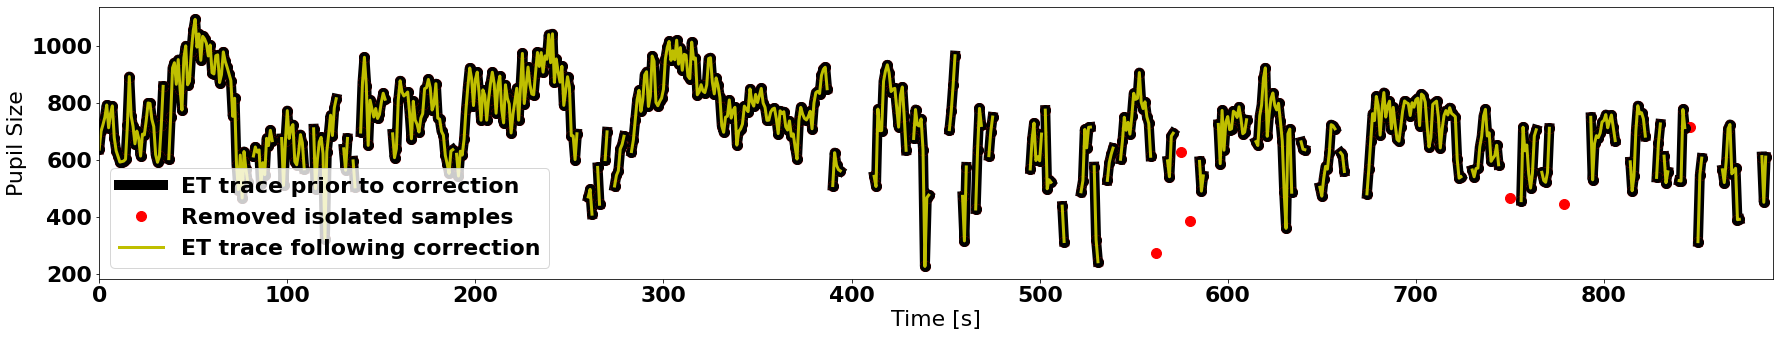

In [20]:
sample_run = '283543_rfMRI_REST1_PA'
before_correction = ET_PupilSize_Proc_1Hz_B_precorrection.copy()
before_correction.index = before_correction.index.total_seconds()
after_correction  = ET_PupilSize_Proc_1Hz_B.copy()
after_correction.index = after_correction.index.total_seconds()
fig, axs = plt.subplots(1,1,figsize=(30,5))
line1    = axs.plot(before_correction[sample_run], 'k', lw=10,  label='ET trace prior to correction')
line2    = axs.plot(before_correction[sample_run], 'r.', lw=1, ms=20, label='Removed isolated samples')
line2    = axs.plot(after_correction[sample_run], 'k.', lw=1, ms=20)
line3    = axs.plot(after_correction[sample_run],  'y', lw=3,  label='ET trace following correction')
axs.set_xlabel('Time [s]')
axs.set_ylabel('Pupil Size')
axs.legend()
axs.set_xlim(0,890)

In [21]:
del before_correction, after_correction
del ET_PupilSize_Proc_1Hz_B_precorrection

### Step 9. Removal of 1s EC events in the middle of long periods of eye opening

Detailed observation of the data showed that sometimes there are single (1s) missing samples in the middle of long periods of eye opening. 

These isolated missing samples break single long period of eye opening into two shorter halves (one before the sample, and one after). 

We beleive it is more appropriate to regard these periods as a single long one, instead of two shorter ones separated by a 1s sample.

In [22]:
precorrection       = ET_PupilSize_Proc_1Hz_B.copy()
precorrection.index = precorrection.index.total_seconds()

In [23]:
%%time
for run in ET_PupilSize_Proc_1Hz_B.columns:
    s=ET_PupilSize_Proc_1Hz_B[run].copy()
    # Interpolate begining and end if necessary
    if (np.isnan(s[0])==True) &  (np.isnan(s[1])==False):
        s[0] = s[1]
    if (np.isnan(s[-1])==True) &  (np.isnan(s[-2])==False):
        s[-1] = s[-2]
    # Interpolate anything else in the middle
    s[s.isnull()] = (s.shift(-1) + s.shift(1))/2
    ET_PupilSize_Proc_1Hz_B[run]=s

CPU times: user 987 ms, sys: 13.2 ms, total: 1 s
Wall time: 1e+03 ms


In [24]:
sample_run           = '782561_rfMRI_REST4_AP'
postcorrection       = ET_PupilSize_Proc_1Hz_B.copy()
postcorrection.index = postcorrection.index.total_seconds()

(0.0, 300.0)

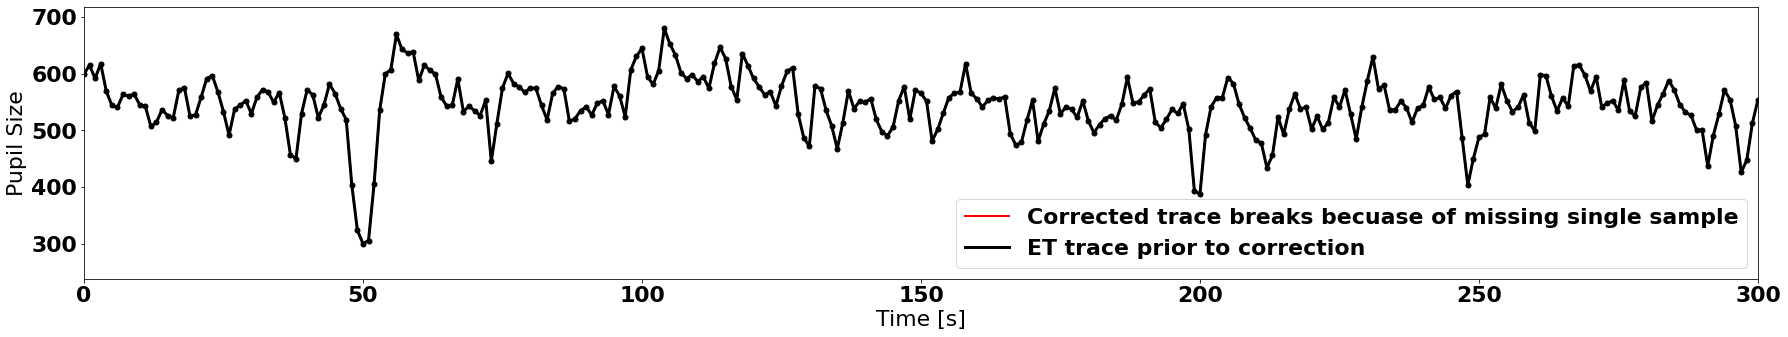

In [25]:
fig, axs = plt.subplots(1,1,figsize=(30,5))
line3    = axs.plot(postcorrection[sample_run], 'r', lw=2, label='Corrected trace breaks becuase of missing single sample')
line1    = axs.plot(precorrection[sample_run], 'k', lw=3,  label='ET trace prior to correction')
line2    = axs.plot(precorrection[sample_run], 'k.', lw=1, ms=10)
axs.set_xlabel('Time [s]')
axs.set_ylabel('Pupil Size')
axs.legend()
axs.set_xlim(0,300)

In [26]:
del postcorrection, precorrection

# 4. Save fully pre-processed ET data to disk

First, we will save the timeseries for all the good runs into a single pickle file in the Resources directory

In [27]:
ET_PupilSize_Proc_1Hz_B.to_pickle(osp.join(Resources_Dir,'ET_PupilSize_Proc_1Hz_corrected.Sukru.pkl'))

Additionaly, we will also save a copy of the fully pre-processed ET data on each run directory. This time the pickle file will only contain the traces for each particular run separately

In [28]:
%%time
for item in ET_PupilSize_Proc_1Hz_B.columns:
    sbj,run  = item.split('_',1)
    run_dir  = osp.join(DATA_DIR,sbj,run)
    out_path = osp.join(run_dir,'.'.join([run,'ET_PupilSize_Preproc_1Hz_corrected','Sukru','pkl']))
    ET_PupilSize_Proc_1Hz_B.to_pickle(out_path)
    print('++ ET File saved [%s]:' % out_path)

++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/100610/rfMRI_REST1_PA/rfMRI_REST1_PA.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/100610/rfMRI_REST2_AP/rfMRI_REST2_AP.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/100610/rfMRI_REST3_PA/rfMRI_REST3_PA.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/100610/rfMRI_REST4_AP/rfMRI_REST4_AP.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/102311/rfMRI_REST2_AP/rfMRI_REST2_AP.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/102311/rfMRI_REST4_AP/rfMRI_REST4_AP.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/102816/rfMRI_REST1_PA/rfMRI_REST1_PA.ET_PupilSize_Preproc_1Hz_corrected.Sukru.pkl]:
++ ET File saved [/data/SFIMJGC_HCP7T/HCP7T/102816/rfMRI_REST2_AP/rfMRI_REST2_AP.ET_PupilSize_Preproc_1H